# A little bit about this project

Ever wondered how much is your car worth at the moment? Well, you know the situation: you are dreaming of buying a new car and you could use cash from selling your current car but you have no idea how much is that miracle of engineering worth. One way to find out is by going to your country's biggest car ads website like <a href='https://www.mobile.de/'>mobile.de</a> if you are from Germany or to <a href='https://autoplius.lt/'>autoplius.lt</a> if you are from Lithuania like me. Then you check a lot of ads with cars similar to yours and try to calculate some average of what your car could be worth. This method is really time consuming and might not be that accurate. And if you want to follow up on your car's value after some time you have to repeat this process again. Well, this is the problem that we will be addressing here.

Using my beginner data science powers we will be trying to predict current car's value by providing some parameters. At first, we will scrape some data from <a href='https://autoplius.lt/'>autoplius.lt</a> and then we will try to build a model that would predict how much a car is worth. So next time when you will be looking for a new car you will know how much your current car is worth (at least roughly, we'll see about that later on) almost instantaneously and how much money do you need to save for your new purchase :)

Let's go!

## Importing packages

First, let's import some packages for data scraping, manipulation, visualization and model building. We'll be using Linear Regression for our model. You can read more about it <a href='https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares'>here</a>.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

## <span style='color:red'>IMPORTANT! PLEASE READ</span>

Section below includes instructions on how to build your own DataFrame by scraping data from one particular website - autoplius.lt. This section is for reference only, I am asking you not to run this code because you would cause extra load on website's servers. Also, autoplius.lt shows ads in some weird way. If you try to scrape a lot of ads, you will get a lot of duplicates because you would see same ads in several pages. My idea was to get all of the ads but I had to dismiss it because it was quite unreal and I was getting blocked by autoplius.lt, so do not attempt to do this.

Please use DataFrame provided with this project which is a result of running the following code. DataFrame contains Volkswagen Passat ads' data only.

Also the following DataFrame building code will be commented out so it will not run automatically when you run all cells in this notebook.

## Getting data and building DataFrame (reference only)

### Functions to get data

At first, let's define some functions to get desired data. These functions provided with website's content are supposed to go through the whole webpage and return a list consisting of parameters' data.  As I have said previously, we will try to predict car's price based on some parameters. Those parameters are going to be: year, mileage, power and type of gearbox. In addition, we will extract fuel type.

In [2]:
'''
def get_names(soup):
    name_tags = soup.find_all('div', class_='announcement-title')
    names = []
    for tag in name_tags:
        names.append(tag.get_text().strip())
    return names

def get_prices(soup):
    price_tags = soup.find_all('div', class_='announcement-pricing-info')
    prices = []
    for tag in price_tags:
        if tag.strong.find('span', class_='promo-price') is not None:
            price = int(tag.strong.find('span', class_='promo-price').get_text().replace('€', '').replace(' ', ''))
        else:
            price = int(tag.strong.get_text().replace('€', '').replace(' ', ''))
        prices.append(price)
    return prices

def get_years(soup):
    year_tags = soup.find_all(attrs={'title': 'Pagaminimo data'})
    years = []
    for tag in year_tags:
        years.append(tag.get_text())
    return years

def get_mileages(soup):
    mileage_tags = soup.find_all(attrs={'title': 'Rida'})
    mileages = []
    for tag in mileage_tags:
        mileage = tag.get_text().replace(' km', '').replace(' ', '')
        mileages.append(int(mileage))
    return mileages

def get_powers(soup):
    power_tags = soup.find_all(attrs={'title': 'Galia'})
    powers = []
    for tag in power_tags:
        power = tag.get_text().replace(' kW', '')
        powers.append(int(power))
    return powers

def get_gearboxes(soup):
    gearbox_tags = soup.find_all(attrs={'title': 'Pavarų dėžė'})
    gearboxes = []
    for tag in gearbox_tags:
        gearbox = tag.get_text()
        gearboxes.append(gearbox)
    return gearboxes

def get_fuel_types(soup):
    fuel_tags = soup.find_all(attrs={'title': 'Kuro tipas'})
    fuel_types = []
    for tag in fuel_tags:
        fuel = tag.get_text()
        fuel_types.append(fuel)
    return fuel_types
'''

"\ndef get_names(soup):\n    name_tags = soup.find_all('div', class_='announcement-title')\n    names = []\n    for tag in name_tags:\n        names.append(tag.get_text().strip())\n    return names\n\ndef get_prices(soup):\n    price_tags = soup.find_all('div', class_='announcement-pricing-info')\n    prices = []\n    for tag in price_tags:\n        if tag.strong.find('span', class_='promo-price') is not None:\n            price = int(tag.strong.find('span', class_='promo-price').get_text().replace('€', '').replace(' ', ''))\n        else:\n            price = int(tag.strong.get_text().replace('€', '').replace(' ', ''))\n        prices.append(price)\n    return prices\n\ndef get_years(soup):\n    year_tags = soup.find_all(attrs={'title': 'Pagaminimo data'})\n    years = []\n    for tag in year_tags:\n        years.append(tag.get_text())\n    return years\n\ndef get_mileages(soup):\n    mileage_tags = soup.find_all(attrs={'title': 'Rida'})\n    mileages = []\n    for tag in mileage_tags

### Function to build DataFrame

Now let's define a function that will build a DataFrame. This function will create initial DataFrame to build on at first. Then it will count how many pages it needs to go through. Finally, it will go through all those pages by creating DataFrames and stacking them up.

In [3]:
'''
def build_df(link):
    # creating initial DataFrame
    webpage = requests.get(link)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    df = pd.DataFrame({'name': get_names(soup), 'gearbox': get_gearboxes(soup),
                     'fuel': get_fuel_types(soup), 'mfd_date': get_years(soup),
                     'mileage': get_mileages(soup), 'power': get_powers(soup),
                     'price': get_prices(soup)})
    
    # counting pages
    ads = int(soup.find(class_='result-count').get_text().replace('(', '').replace(')', ''))
    pages = int(ads / 20)
    if ads % 20 != 0:
        pages += 1
        
    # building DataFrame
    if pages > 0:
        for page in range(2, pages + 1):
            new_link = link + '&page_nr=' + str(page)
            webpage = requests.get(new_link)
            soup = BeautifulSoup(webpage.content, 'html.parser')
            temp_df = pd.DataFrame({'name': get_names(soup), 'gearbox': get_gearboxes(soup), 'fuel': get_fuel_types(soup), 'mfd_date': get_years(soup), 'mileage': get_mileages(soup), 'power': get_powers(soup), 'price': get_prices(soup)})
            df = pd.concat([df, temp_df])
    
    return df
'''

"\ndef build_df(link):\n    # creating initial DataFrame\n    webpage = requests.get(link)\n    soup = BeautifulSoup(webpage.content, 'html.parser')\n    df = pd.DataFrame({'name': get_names(soup), 'gearbox': get_gearboxes(soup),\n                     'fuel': get_fuel_types(soup), 'mfd_date': get_years(soup),\n                     'mileage': get_mileages(soup), 'power': get_powers(soup),\n                     'price': get_prices(soup)})\n    \n    # counting pages\n    ads = int(soup.find(class_='result-count').get_text().replace('(', '').replace(')', ''))\n    pages = int(ads / 20)\n    if ads % 20 != 0:\n        pages += 1\n        \n    # building DataFrame\n    if pages > 0:\n        for page in range(2, pages + 1):\n            new_link = link + '&page_nr=' + str(page)\n            webpage = requests.get(new_link)\n            soup = BeautifulSoup(webpage.content, 'html.parser')\n            temp_df = pd.DataFrame({'name': get_names(soup), 'gearbox': get_gearboxes(soup), 'fuel': g

### Building DataFrame

Finally, we are building a DataFrame! In order for our future model to work better and for cleaner data we will use some of website's filters when generating a link:
<li>Power >25kW - to make sure that only ads with provided power are shown</li>
<li>Mileage >0km - to make sure that only ads with provided mileage are shown</li>
<li>No defects - no damaged cars in any ways</li>
<li>No RHD (right hand drive) - only typical cars (LHD) for Lithuania</li>
<li>Ads should be ordered by newest first</li>

In [4]:
'''
link = 'https://autoplius.lt/skelbimai/naudoti-automobiliai?make_date_from=&make_date_to=&sell_price_from=&sell_price_to=&engine_capacity_from=&engine_capacity_to=&power_from=25&power_to=&kilometrage_from=0&kilometrage_to=&qt=&has_damaged_id=10924&steering_wheel_id=10922&category_id=2&make_id=43&model_id=186&order_by=3&order_direction=DESC'
df = build_df(link)

# check how many cars we got
df.info()

# check if there are duplicates, hopefully there aren't
len(df[df.duplicated()])
'''

"\nlink = 'https://autoplius.lt/skelbimai/naudoti-automobiliai?make_date_from=&make_date_to=&sell_price_from=&sell_price_to=&engine_capacity_from=&engine_capacity_to=&power_from=25&power_to=&kilometrage_from=0&kilometrage_to=&qt=&has_damaged_id=10924&steering_wheel_id=10922&category_id=2&make_id=43&model_id=186&order_by=3&order_direction=DESC'\ndf = build_df(link)\n\n# check how many cars we got\ndf.info()\n\n# check if there are duplicates, hopefully there aren't\nlen(df[df.duplicated()])\n"

Resetting index:

In [5]:
'''
df.reset_index(inplace=True, drop=True)
'''

'\ndf.reset_index(inplace=True, drop=True)\n'

Saving DataFrame to a .csv file:

In [6]:
'''
df.to_csv('cars.csv')
'''

"\ndf.to_csv('cars.csv')\n"

## Loading DataFrame

Let's try to load the same DataFrame that we would get by running code above back from .csv file and inspect it.

In [7]:
cars = pd.read_csv('cars.csv')
cars = cars.drop(['Unnamed: 0'], axis=1)
cars.info()
cars.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 7 columns):
name        1185 non-null object
gearbox     1185 non-null object
fuel        1185 non-null object
mfd_date    1185 non-null object
mileage     1185 non-null int64
power       1185 non-null int64
price       1185 non-null int64
dtypes: int64(3), object(4)
memory usage: 64.9+ KB


,name,gearbox,fuel,mfd_date,mileage,power,price
0,"Volkswagen Passat, 2.0 l., universalas",Automatinė,Dyzelinas,2018-12,18000,110,16999
1,"Volkswagen Passat, 1.9 l., universalas",Mechaninė,Dyzelinas,2002-11,295100,74,1400
2,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2006-12,260800,103,3000
3,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2009-04,297340,103,2700
4,"Volkswagen Passat, 2.0 l., universalas",Automatinė,Dyzelinas,2007-11,271200,103,2999
5,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2013-03,240000,103,8000
6,"Volkswagen Passat, 1.8 l., universalas",Mechaninė,Benzinas / dujos,1998,258415,110,750
7,"Volkswagen Passat, universalas",Mechaninė,Dyzelinas,1999,380000,66,600
8,"Volkswagen Passat, 1.6 l., sedanas",Mechaninė,Benzinas,2005-07,210000,85,2800
9,"Volkswagen Passat, 1.9 l., sedanas",Mechaninė,Dyzelinas,2000,270000,96,1200


## Reshaping data

For our model to work we will need to reshape some data. First, we will create a new column for type of gearbox which will be True if gearbox is automatic and False otherwise. Second, we will extract year from mfd_date (manufactured date) into a new column. After that we'll check what our data looks like now.

In [8]:
# creating column for gearbox type
cars['auto_gearbox'] = cars['gearbox'] == 'Automatinė'

# creating column for year
cars['year'] = cars['mfd_date'].apply(lambda x: int(x[:4]))

cars.head(10)

,name,gearbox,fuel,mfd_date,mileage,power,price,auto_gearbox,year
0,"Volkswagen Passat, 2.0 l., universalas",Automatinė,Dyzelinas,2018-12,18000,110,16999,True,2018
1,"Volkswagen Passat, 1.9 l., universalas",Mechaninė,Dyzelinas,2002-11,295100,74,1400,False,2002
2,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2006-12,260800,103,3000,False,2006
3,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2009-04,297340,103,2700,False,2009
4,"Volkswagen Passat, 2.0 l., universalas",Automatinė,Dyzelinas,2007-11,271200,103,2999,True,2007
5,"Volkswagen Passat, 2.0 l., universalas",Mechaninė,Dyzelinas,2013-03,240000,103,8000,False,2013
6,"Volkswagen Passat, 1.8 l., universalas",Mechaninė,Benzinas / dujos,1998,258415,110,750,False,1998
7,"Volkswagen Passat, universalas",Mechaninė,Dyzelinas,1999,380000,66,600,False,1999
8,"Volkswagen Passat, 1.6 l., sedanas",Mechaninė,Benzinas,2005-07,210000,85,2800,False,2005
9,"Volkswagen Passat, 1.9 l., sedanas",Mechaninė,Dyzelinas,2000,270000,96,1200,False,2000


## Cleaning data

Now we should clean our data a little bit. I would like to delete unrealistic ads that could cause some problems for our future model. At first, we will drop all cars with mileage over 500k kilometres. Secondly, we will drop all cars with mileage less than 10k kilometres and price less than 5k euros (there aren't almost new cars that would cost 5k euros or less really). Lastly, we'll check how many cars we have left after the cleaning.

In [9]:
# dropping cars where mileage is over 500K kilometres (these ads are mostly unrealistic)
cars = cars[cars['mileage'] <= 500000]

# dropping cars with unrealistic mileage and price combination
cars = cars[((cars['mileage'] < 10000) & (cars['price'] > 5000)) | (cars['mileage'] > 10000)]

len(cars)

1166

## Analyzing data

Before we dive into model making process, let's analyze our DataFrame a little bit. Who knows, maybe we will find something interesting? At first, let's use pandas .describe() method.

In [10]:
cars.describe()

,mileage,power,price,year
count,1166.000000,1166.000000,1166.000000,1166.000000
mean,215411.854202,102.497427,7134.086621,2009.665523
std,85067.932030,19.185328,6108.721798,5.934952
min,0.000000,40.000000,250.000000,1990.000000
25%,168856.000000,88.000000,2700.000000,2006.000000
50%,221321.000000,103.000000,4300.000000,2010.000000
75%,269750.000000,110.000000,10500.000000,2015.000000
max,460000.000000,206.000000,36000.000000,2020.000000


We can see that we have data on around 1k cars and that data is quite rich in variety. We have old cars that we could call youngtimers (20-30 years old) and we have brand new cars. We have cars that cost no more than a sofa while others would require a decent amount of money. However by looking at median of price (4300 euros) we can see that the average car in our DataFrame is not very pricey. Also 50 percent of cars are powered by engines that have between 88 and 110 kilowatts, nothing fancy here. One thing that should get our attention is mileage. Even at first quartile we see a mileage of around 170k kilometres, that is quite a big number! At second quartile we get a number that is bigger than 200k kilometres, which is a threshold for some buyers when deciding if he/she should buy this car or not. We can definitely say that Volkswagen Passats are mostly used for work and long travels.

I think it's time to do some plots now.

Although we won't use fuel type for our model, it's still interesting to explore this parameter. Let's see how our cars are distributed by fuel type

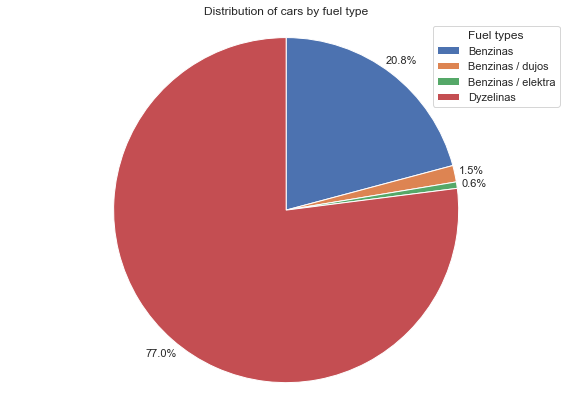

In [11]:
cars_by_fuel = cars.groupby('fuel').name.count().reset_index()

sns.set_palette('deep')
sns.set(style='white')
fig1, ax1 = plt.subplots(figsize=(10, 7))
ax1.pie(x=cars_by_fuel['name'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 11}, pctdistance=1.1, counterclock=False)
ax1.axis('equal')
ax1.set_title('Distribution of cars by fuel type')
ax1.legend(cars_by_fuel['fuel'], title='Fuel types', loc=1)
plt.show()

We can see clearly that diesel dominates here, followed by gasoline. There aren't much alternatives to those two fuel types but you might find a car powered by gasoline plus LPG or gasoline plus electricity. Let's check if some of the fuel types are getting more popular today. We'll look at data from 1995 because there isn't enough data for prior years.

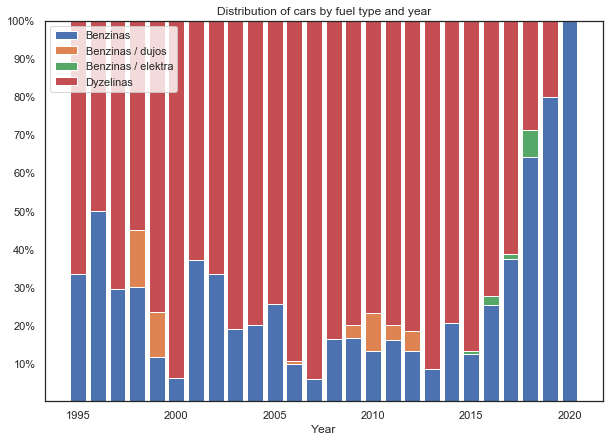

In [12]:
cars_by_year_fuel = cars.groupby(['year', 'fuel']).name.count().reset_index()
cars_by_year = cars.groupby('year').name.count().reset_index()

fuel_types = cars_by_fuel['fuel']
percentages_fuel = [[] for fuel in fuel_types]
years = list(range(1995, 2021))

for year in years:
    for i in range(len(fuel_types)):
        try:
            percent = 100.0 * cars_by_year_fuel[(cars_by_year_fuel.year == year) & (cars_by_year_fuel.fuel == fuel_types[i])].name.values[0] / cars_by_year[cars_by_year['year'] == year].name.values[0]
            percentages_fuel[i].append(percent)
        except:
            percentages_fuel[i].append(0)
            
bottom_1 = [percentages_fuel[0][i] + percentages_fuel[1][i] for i in range(len(years))]
bottom_2 = [percentages_fuel[0][i] + percentages_fuel[1][i] + percentages_fuel[2][i] for i in range(len(years))]

fig2, ax2 = plt.subplots(figsize=(10, 7))
ax2.bar(years, percentages_fuel[0])
ax2.bar(years, percentages_fuel[1], bottom=percentages_fuel[0])
ax2.bar(years, percentages_fuel[2], bottom=bottom_1)
ax2.bar(years, percentages_fuel[3], bottom=bottom_2)
ax2.set_title('Distribution of cars by fuel type and year')
ax2.set_xlabel('Year')
ax2.legend(fuel_types, loc=2)
ax2.set_yticks(range(10, 110, 10))
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.show()

From the chart above we can see that up to around 2015 diesel was surely dominating the market but then the whole Dieselgate situation broke out and that trend reversed. From 2015 gasoline is getting more and more popular.

Now let's see what we can dig about gearboxes.

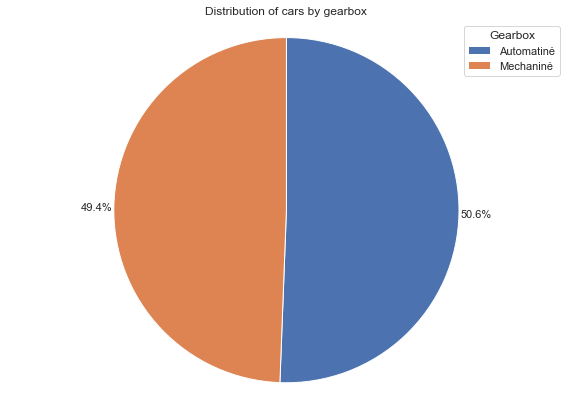

In [13]:
cars_by_gearbox = cars.groupby('gearbox').name.count().reset_index()

fig3, ax3 = plt.subplots(figsize=(10, 7))
ax3.pie(x=cars_by_gearbox['name'], startangle=90, autopct='%1.1f%%', textprops={'fontsize': 11}, pctdistance=1.1, counterclock=False)
ax3.axis('equal')
ax3.set_title('Distribution of cars by gearbox')
ax3.legend(cars_by_gearbox['gearbox'], title='Gearbox', loc=1)
plt.show()

Okay, we see that half of cars in our DataFrame have automatic gearboxes and the other half have manual gearboxes. Once again let's see the distribution of our parameter by year, maybe we will find some trend here too? Again, we'll look at data only from 1995.

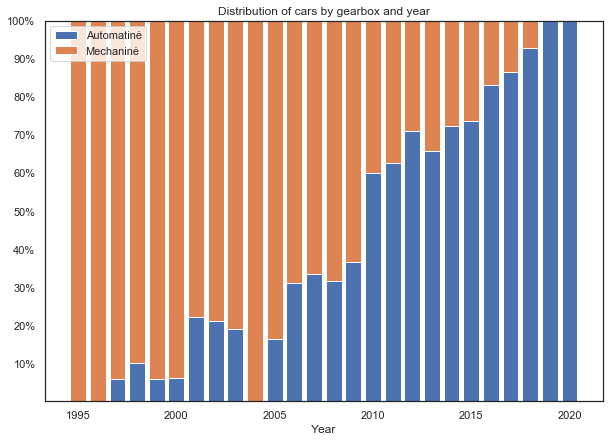

In [14]:
cars_by_year_gearbox = cars.groupby(['year', 'gearbox']).name.count().reset_index()

gearboxes = cars_by_gearbox['gearbox']
percentages_gearbox = [[] for gearbox in gearboxes]

for year in years:
    for i in range(len(gearboxes)):
        try:
            percent = 100.0 * cars_by_year_gearbox[(cars_by_year_gearbox.year == year) & (cars_by_year_gearbox.gearbox == gearboxes[i])].name.values[0] / cars_by_year[cars_by_year['year'] == year].name.values[0]
            percentages_gearbox[i].append(percent)
        except:
            percentages_gearbox[i].append(0)
            
fig4, ax4 = plt.subplots(figsize=(10, 7))
ax4.bar(years, percentages_gearbox[0])
ax4.bar(years, percentages_gearbox[1], bottom=percentages_gearbox[0])
ax4.set_title('Distribution of cars by gearbox and year')
ax4.set_xlabel('Year')
ax4.legend(gearboxes, loc=2)
ax4.set_yticks(range(10, 110, 10))
ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.show()

The trend is very clear here: in 25 years we went from mostly manual gearboxes to mostly automatic. Well nowadays automatic gearboxes offer same or better fuel consumption, acceleration and so on, but most important they are way more convenient if you live in a big city and have to deal with traffic jams, so no surprise in this chart really.

Let's continue. We should check what age cars are the most popular among lithuanian sellers.

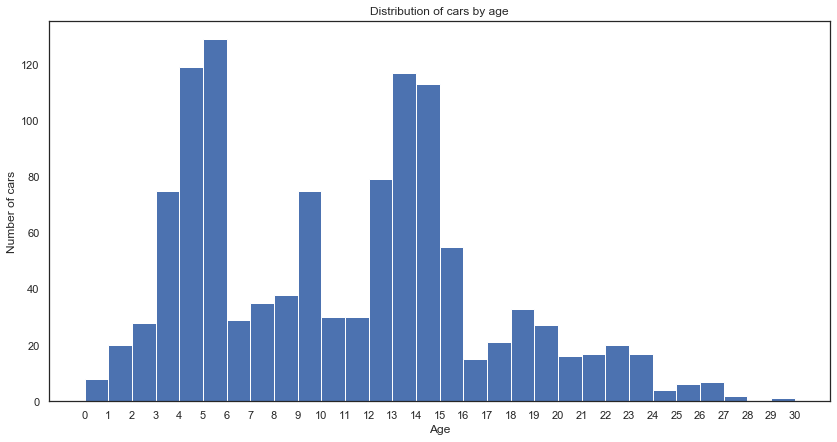

In [15]:
cars_age = cars['year'].reset_index()
year_now = datetime.datetime.now().year
cars_age['age'] = year_now - cars_age['year']

fig5, ax5 = plt.subplots(figsize=(14, 7))
ax5.hist(cars_age['age'], bins=(cars_age['age'].max() - cars_age['age'].min()))
ax5.set_title('Distribution of cars by age')
ax5.set_xlabel('Age')
ax5.set_ylabel('Number of cars')
ax5.set_xticks(range(cars_age['age'].max() + 1))
plt.show()

We can see two peaks so it is a bimodal distribution. One peak lies at around 4-5 years and another one at 13-14 years. It looks like that people with good salaries tend to buy pretty new cars while people with limited budget have to do with 10 years older cars.

Now let's try to answer question are cars getting more powerful or not.

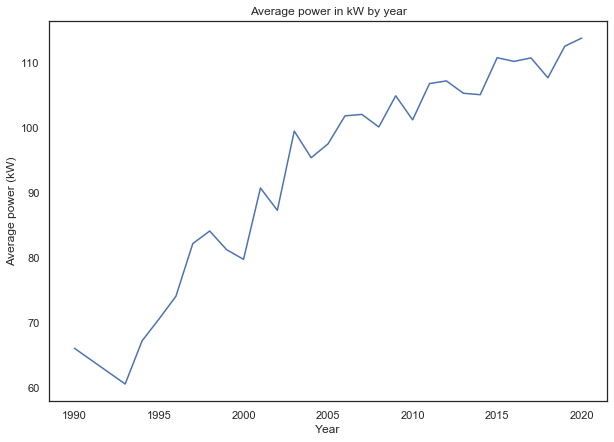

In [16]:
cars_power = cars.groupby('year').power.mean().reset_index()

fig6, ax6 = plt.subplots(figsize=(10, 7))
ax6.plot(cars_power['year'], cars_power['power'])
ax6.set_title('Average power in kW by year')
ax6.set_xlabel('Year')
ax6.set_ylabel('Average power (kW)')
plt.show()

We can clearly see a trend upwards here: cars are getting more and more powerful. However the increment in power has significantly slowed in past 15 years. Well how fast can you go anyways?

The last question we are going to answer is do cars with diesel powered engines have higher average mileage than gasoline powered ones?

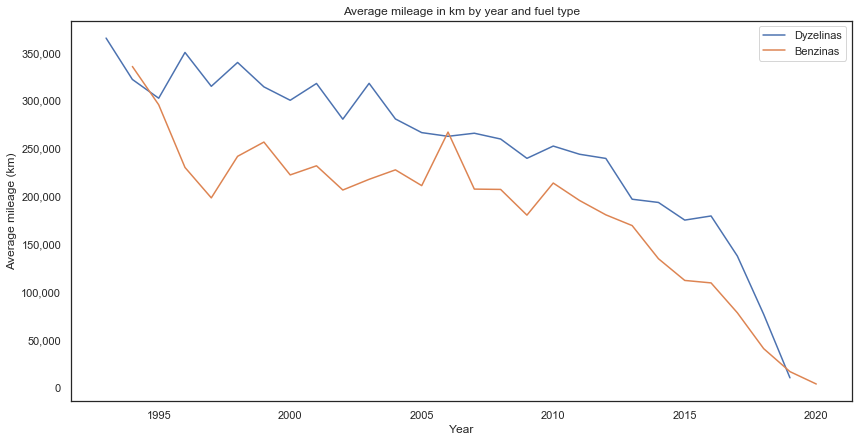

In [17]:
cars_fuel_mileage = cars[['fuel', 'year', 'mileage']]
cars_fuel_mileage = cars_fuel_mileage[(cars_fuel_mileage['fuel'] == 'Benzinas') | (cars_fuel_mileage['fuel'] == 'Dyzelinas')]

fig7 = plt.subplots(figsize=(14, 7))
ax7 = sns.lineplot(x='year', y='mileage', hue='fuel', data=cars_fuel_mileage, ci=None, legend=False)
ax7.set_title('Average mileage in km by year and fuel type')
ax7.set_xlabel('Year')
ax7.set_ylabel('Average mileage (km)')
ax7.legend(['Dyzelinas', 'Benzinas'])
ax7.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

We see that cars with diesel powered engines have higher average mileage by quite wide margin than gasoline powered ones. This is worth considering when thinking of buying a new car.

Okay, so let's do a quick summary of what we found out:
<ol>
    <li>Gasoline powered engines are becoming more popular than diesel powered ones.</li>
    <li>Automatic gearboxes have almost driven out manual gearboxes.</li>
    <li>Most popular cars among lithuanian folks are aged between 4 and 5 and between 13 and 14 years.</li>
    <li>Cars are getting more powerful engines.</li>
    <li>Diesel powered cars have higher average mileage when comparing to gasoline powered ones.</li>
</ol>
It's time to get back to making our model!

## Correlation

As I have mentioned earlier, we are going to predict cars' price by providing year, mileage, power and gearbox type. Let's see what is the correlation between these parameters and price. Can they be proper candidates for our model? 

In [18]:
cars.corr()

,mileage,power,price,auto_gearbox,year
mileage,1.000000,-0.305071,-0.779167,-0.411886,-0.695391
power,-0.305071,1.000000,0.411427,0.439961,0.433821
price,-0.779167,0.411427,1.000000,0.533310,0.840613
auto_gearbox,-0.411886,0.439961,0.533310,1.000000,0.544868
year,-0.695391,0.433821,0.840613,0.544868,1.000000


We can see a very strong positive relationship between year and price. As the year of production goes down (car gets older), so does the price of the car. Also there is a strong correlation between mileage and price, but this time it is negative. As the mileage goes up, the price of the car goes down. There are also positive but significantly weaker relationships between power and price and gearbox type and price. Those relationships suggest that cars with more powerful engines cost more and so it's the same with cars having automatic versus manual gearboxes.

Let's do scatter plots of these parameters versus price just to visually support these statements.

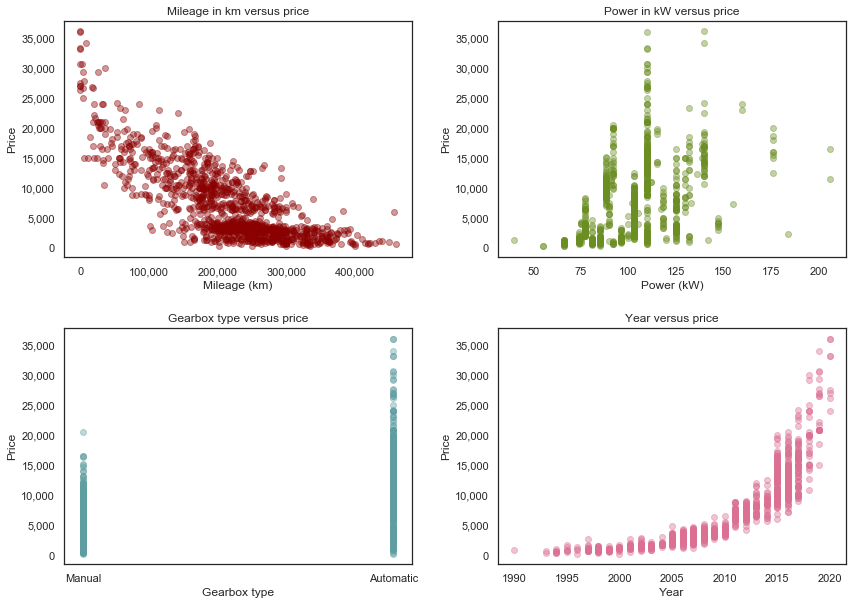

In [19]:
fig8, axs1 = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

# mileage vs price
axs1[0, 0].scatter(cars.mileage, cars.price, c='darkred', alpha=0.4)
axs1[0, 0].set_xlabel('Mileage (km)')
axs1[0, 0].set_title('Mileage in km versus price')
axs1[0, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
for ax in axs1.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_ylabel('Price')

# power vs price
axs1[0, 1].scatter(cars.power, cars.price, c='olivedrab', alpha=0.4)
axs1[0, 1].set_xlabel('Power (kW)')
axs1[0, 1].set_title('Power in kW versus price')

# gearbox vs price
axs1[1, 0].scatter(cars.auto_gearbox, cars.price, c='cadetblue', alpha=0.4)
axs1[1, 0].set_xlabel('Gearbox type')
axs1[1, 0].set_title('Gearbox type versus price')
axs1[1, 0].set_xticks([0, 1])
axs1[1, 0].set_xticklabels(['Manual', 'Automatic'])

# year vs price
axs1[1, 1].scatter(cars.year, cars.price, c='palevioletred', alpha=0.4)
axs1[1, 1].set_xlabel('Year')
axs1[1, 1].set_title('Year versus price')

plt.show()

#### Mileage vs price
Cars with 0 kilometres mileage cost at least 25k euros, while cars with mileage over 350k kilometres cost no more than 10k euros, so we can see a negative correlation. However trying to predict car's price based solely on mileage could prove to be a hard task because a car with mileage around 200k kilometres as our data shows could cost from almost 0 to 20k euros, what a wide range!

#### Power vs price
We can see some correlation here, still a car powered with around 110 kw engine could cost from nearly nothing to 35k euros, so power alone doesn't say much about price.

#### Gearbox type vs price
Again, there is some weak correlation between gearbox type and price, by looking at chart you can predict with some confidence that there is a very small probability that a car with manual gearbox will cost more than 20k euros.

#### Year vs price
It's very easy to see that correlation here is the strongest one. Car's price drops very fast in first five years and it would be quite hard to guess such car's price but after that the decline slows down and price fluctuation narrows down.

It seems that all these parameters when taken alone do not promise very much accuracy. But if we combine them together maybe we will be able to predict car's price with some confidence. Let's start building our model!

## Selecting data for multiple linear regression

First step is to select data for our multiple linear regression model. We will try to predict car's price by providing mileage, power, year and gearbox type.

In [20]:
prices = cars['price']
features = cars[['mileage', 'power', 'year', 'auto_gearbox']]

## Splitting data into training and testing sets

Second step is to split the data into training and testing sets. We will use 80 percent of the data for training our model and the remaining 20 percent for testing it. We will use test data to evaluate our model if it is any good.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=1)

## Creating and training the model

Now let's create linear regression model and fit it with training data.

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Evaluating model

It's time for the showdown - is our model any good? Let's check what score our model gets. The best possible score can be 1.0

In [23]:
model.score(X_test, y_test)

0.8019053175571724

It seems that our model is pretty decent. Let's try to predict a particular car's price. Based on my experience it should cost around 7k euros.

In [24]:
# features: 'mileage', 'power', 'year', 'auto_gearbox'
my_features = np.array([230000, 125, 2012, 1]).reshape(1, -1)
int(model.predict((my_features)))

8771

Our model predicts that car in question should cost almost 9k euros and I really don't think this is the right price, but that's just one car. Let's visualize our model's predicted prices of test data versus real prices.

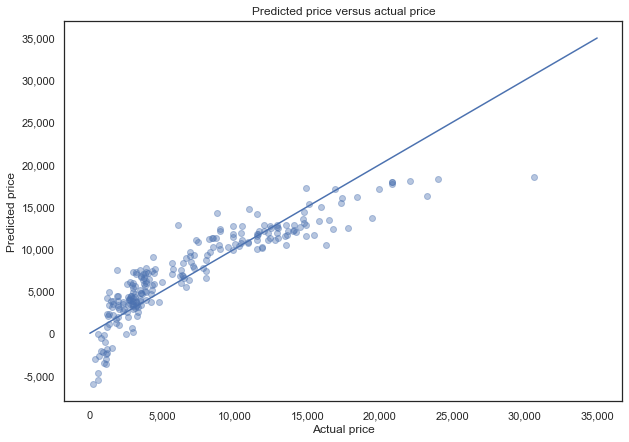

In [25]:
fig9, ax9 = plt.subplots(figsize=(10, 7))
ax9.scatter(y_test, model.predict(X_test), alpha=0.4)
ax9.set_title('Predicted price versus actual price')
ax9.set_xlabel('Actual price')
ax9.set_ylabel('Predicted price')
ax9.set_yticks(range(-5000, 35001, 5000))
ax9.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax9.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax9.plot(range(35000), range(35000))
plt.show()

Okay, so we scattered predicted prices against actual prices and we added a line that would show where ideally all points should be. First thing that you can notice is that our model predicts that some cars would cost a negative amount of money, that is trully ridiculous. Also in the range where actual prices would be between 3k and 12k euros model predicts higher prices, while below 3k and over 12k euros model usually predicts lower prices than actual ones. We should not be happy with this model.

Let's do one more thing: let's plot predicted prices of all cars versus year and compare that chart with actual prices versus year.

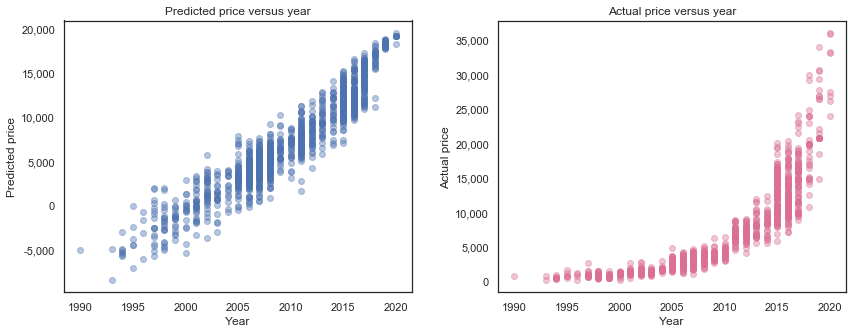

In [26]:
fig10, axs2 = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.25)

axs2[0].scatter(features['year'], model.predict(features), alpha=0.4)
axs2[0].set_title('Predicted price versus year')
axs2[0].set_xlabel('Year')
axs2[0].set_ylabel('Predicted price')
axs2[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs2[1].scatter(cars.year, cars.price, c='palevioletred', alpha=0.4)
axs2[1].set_title('Actual price versus year')
axs2[1].set_xlabel('Year')
axs2[1].set_ylabel('Actual price')
axs2[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

Now if you compare those two charts above you should notice a problem. In the chart on the left we can see that there is a linear relationship between prices and year, while in the chart on the right we clearly see exponential relationship between prices and year. Our model is not suited for exponential data because it is a linear regression model, that means it should be given linear data. Let's fix this!

## Building a new model

What we need to do now is we need to get natural logarithms of prices. Then we will build a new model with newly constructed price data.

In [27]:
prices_log = np.log(prices)

Let's visualize relationships between price and our parameters now.

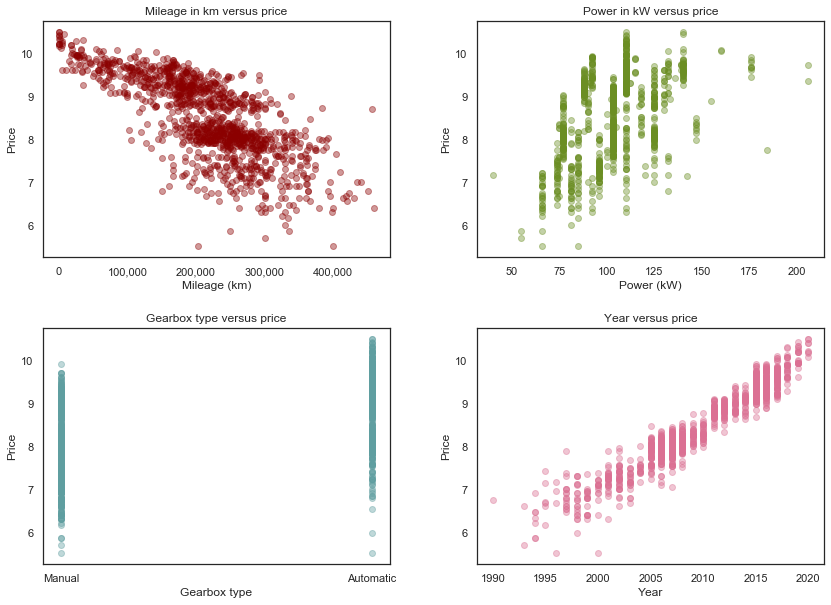

In [28]:
fig11, axs3 = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(wspace=0.25, hspace=0.3)

# mileage vs price
axs3[0, 0].scatter(cars.mileage, prices_log, c='darkred', alpha=0.4)
axs3[0, 0].set_xlabel('Mileage (km)')
axs3[0, 0].set_title('Mileage in km versus price')
axs3[0, 0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
for ax in axs3.flat:
    ax.set_ylabel('Price')

# power vs price
axs3[0, 1].scatter(cars.power, prices_log, c='olivedrab', alpha=0.4)
axs3[0, 1].set_xlabel('Power (kW)')
axs3[0, 1].set_title('Power in kW versus price')

# gearbox vs price
axs3[1, 0].scatter(cars.auto_gearbox, prices_log, c='cadetblue', alpha=0.4)
axs3[1, 0].set_xlabel('Gearbox type')
axs3[1, 0].set_title('Gearbox type versus price')
axs3[1, 0].set_xticks([0, 1])
axs3[1, 0].set_xticklabels(['Manual', 'Automatic'])

# year vs price
axs3[1, 1].scatter(cars.year, prices_log, c='palevioletred', alpha=0.4)
axs3[1, 1].set_xlabel('Year')
axs3[1, 1].set_title('Year versus price')

plt.show()

We can't tell much about types of relationships between price versus gearbox and price versus power, but we can clearly see that relationships between price versus mileage and price versus year are now more linear than exponential. That means that our data should now fit linear regression model. So let's split our new data into training and testing sets.

In [29]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(features, prices_log, test_size=0.2, random_state=1)

It's time to build our model and to see what score will we get now.

In [30]:
model_new = LinearRegression()
model_new.fit(X_train_new, y_train_new)
model_new.score(X_test_new, y_test_new)

0.9318055222727628

Wow! We got a really high score! Let's see what price will this model predict for the same car parameters that we had earlier. Note: we need to get exponentials of our further price data.

In [31]:
int(np.exp(model_new.predict((my_features))))

6953

Now I think we get a good result, but let's see predicted prices for test data.

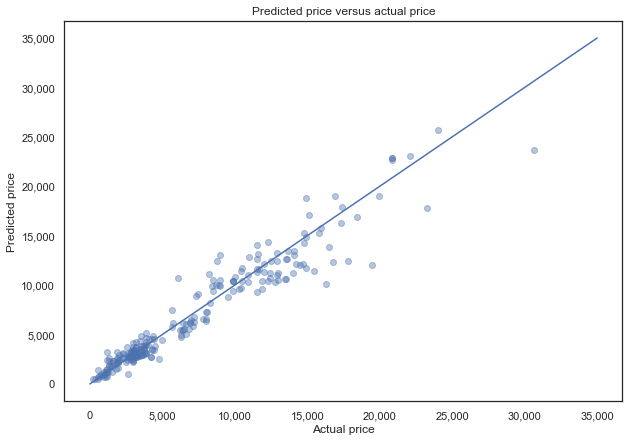

In [32]:
fig12, ax12 = plt.subplots(figsize=(10, 7))
ax12.scatter(np.exp(y_test_new), np.exp(model_new.predict(X_test_new)), alpha=0.4)
ax12.set_title('Predicted price versus actual price')
ax12.set_xlabel('Actual price')
ax12.set_ylabel('Predicted price')
ax12.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax12.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax12.plot(range(35000), range(35000))
plt.show()

With this new model we don't get negative prices, that is one achievement. Another thing is that now our prices are more evenly distributed around the ideal line. Well, let's do one more thing. Let's compare charts of predicted and actual prices versus year.

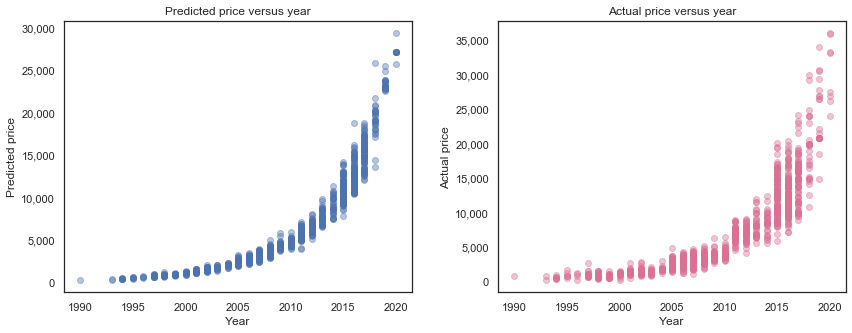

In [33]:
fig13, axs4 = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.25)

axs4[0].scatter(features['year'], np.exp(model_new.predict(features)), alpha=0.4)
axs4[0].set_title('Predicted price versus year')
axs4[0].set_xlabel('Year')
axs4[0].set_ylabel('Predicted price')
axs4[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

axs4[1].scatter(cars.year, cars.price, c='palevioletred', alpha=0.4)
axs4[1].set_title('Actual price versus year')
axs4[1].set_xlabel('Year')
axs4[1].set_ylabel('Actual price')
axs4[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

Well done! Both charts look really similar, now we can see an exponential relationship between our predicted prices and year.

Of course our model won't be 100 percent accurate, we can tell that by looking at charts above, but it should do a pretty good job when trying to predict what a car should be worth.

## EXTRA part - depreciation over time

I thought it would be interesting to know how much does a car depreciate over time. Let's say you are thinking of buying a new car and you would like to know how much money you will lose over a period of some time.

First, let's get the average prices of cars by year. We will compare this data to our model's output.

In [45]:
avg_prices = cars.groupby('year').price.mean().reset_index().sort_values(by='year', ascending=False)
avg_prices.head()

,year,price
28,2020,30344.625000
27,2019,24089.950000
26,2018,19122.714286
25,2017,14928.813333
24,2016,12661.991597


Now we will define a function which takes power, type of gearbox, number of years and kilometres per year as parameters and returns a list with prices of a car in each year, starting at 0 year (brand new car).

In [38]:
def calculate_prices(power, auto_gearbox, period, mileage_per_year):
    prices = []
    mileage = 0
    for i in range(period + 1):
        features = np.array([mileage, power, (year_now - i), auto_gearbox]).reshape(1, -1)
        price = int(np.exp(model_new.predict((features))))
        prices.append(price)
        mileage += mileage_per_year
    return prices

Okay, let's say we have bought a new car with 125 kW engine and automatic gearbox. We would like to know how much will our car depreciate over a period of 10 years and we want to see prices for two scenarios: one is that we drive 15k kilometres each year, second is 30k kilometres each year. Let's calculate that.

In [44]:
prices1 = calculate_prices(125, 1, 10, 15000)
prices2 = calculate_prices(125, 1, 10, 30000)

Last step is to visualize our depreciation data. We will plot average prices by car's age and our two scenarios.

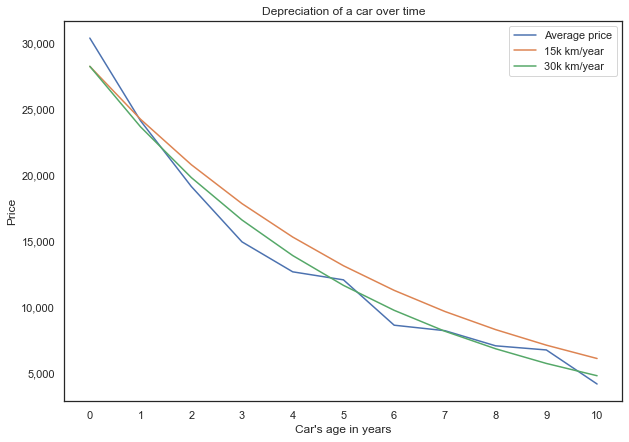

In [59]:
fig14, ax14 = plt.subplots(figsize=(10, 7))
ax14.plot(avg_prices.price.iloc[0:11].to_numpy())
ax14.plot(prices1)
ax14.plot(prices2)
ax14.set_title('Depreciation of a car over time')
ax14.set_xlabel('Car\'s age in years')
ax14.set_ylabel('Price')
ax14.set_xticks(range(11))
ax14.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax14.legend(['Average price', '15k km/year', '30k km/year'])
plt.show()

We can see that our modelled prices go down very close to the average prices, though real depreciation might be a little bit steeper. Nevertheless let's calculate what is the average annual percent of loss in value in our two scenarios.

In [78]:
# 15k km/year
percent1 = round(((prices1[-1] / prices1[0]) ** (1.0/10) - 1) * 100, 2)
print(prices1[0], prices1[-1], percent1)

# 30k km/year
percent2 = round(((prices2[-1] / prices2[0]) ** (1.0/10) - 1) * 100, 2)
print(prices2[0], prices2[-1], percent2)

28207 6105 -14.19
28207 4802 -16.23


Okay, so if you drive 15k km each year, then after 10 years your car's value will go from 28207 euros to 6105 euros and this will be equal to 14.19 average annual percent of loss in value. If you double the kilometres you drive each year, then your car after ten years will cost 4802 euros and this will mean that you have lost around 16.23 percent in value each year. I guess we can say that mileage is important, but car's age matters more.